## Safer routes with open data

Can we use open data to find safer travelling routes within the UK?

For example, cycling routes that avoid dangerous roads, or walking routes that avoid crime hotspots?

This Python notebook illustrates one approach: using open data on roads, crime and accidents to find lower-risk routes.

(Inspired by a friend changing their commute from driving to cycling and the pros and cons of various routes.)

### Import libraries
We'll use various tools, including [(Geo)Pandas](http://geopandas.org/), [Shapely](https://shapely.readthedocs.io/en/stable/manual.html) and [NetworkX](https://networkx.github.io):

In [1]:
%matplotlib inline
import os
import glob
import shapely
import geopandas as gpd
import networkx as nx

### Load Open Roads data
Open Roads, [open data from Ordnance Survey](https://www.ordnancesurvey.co.uk/business-and-government/products/os-open-roads.html), is a 'high-level' view of the British road network.

(This notebook contains OS data © Crown copyright and database right 2018.)

The data has some limitations: it doesn't indicate one way streets, so is a bit limiting for route-finding on a bike.

Open Roads comes in Shapefiles of 100 x 100km. Let's load the SU square into a GeoDataFrame:

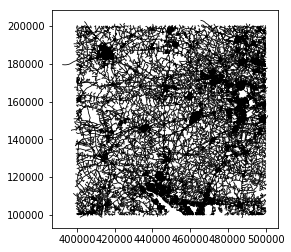

In [2]:
road_shp = os.path.join("/", "Users", "jamie", "Downloads", "oproad_essh_gb", "data", "SU_RoadLink.shp")
road_data = gpd.read_file(road_shp)

road_data.plot(color="black", linewidth=.8)

Each road is split into multiple separate sections (whenever it intersects with another road), stored as [LineStrings](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry).

For example, the stretch of M3 passing through the SU square is split into 132 distinct sections:

132


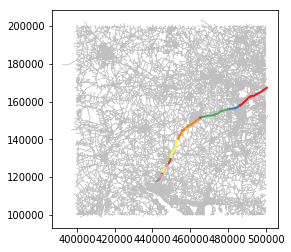

In [3]:
m3 = road_data.loc[road_data["roadNumber"] == "M3"]
print(len(m3))

ax = road_data.plot(color="silver", linewidth=.8)
m3.plot(ax=ax, cmap="Set1", linewidth=2)

Let's zoom in to Southampton, centering on the SE point of Southampton Common.

You can see the Common in the middle and the Itchen river to the east by the lack of roads:

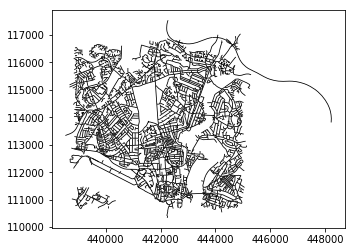

In [4]:
centre = (441922, 113734) # easting, northing of the SE point of the Common
margin = 3000

road_data = road_data.cx[
    centre[0]-margin:centre[0]+margin, # Select a 6x6km area
    centre[1]-margin:centre[1]+margin
]

road_data.plot(color="black", linewidth=.8)

### Make a road network
To use route-finding algorithms, we need to the turn the geographical data into a network (or graph), where:
* Edges are straight-line sections of road, and
* Nodes are corners within road sections and/or junctions between roads

We'll also give the roads (edges) a 'length' attribute corresponding to the length of that section in metres.

We'll use NetworkX for this:

In [5]:
graph = nx.Graph()

for index, row in road_data.iterrows():
    line = row["geometry"]
    no_of_edges = len(line.coords) - 1 # No. of sections within each road-segment
    edge_length = line.length / no_of_edges # Distribute segment length equally between edges
    for i in range(0, len(line.coords)-1):
        graph.add_edge(
            (line.coords[i][0], line.coords[i][1]), # Start easting and northing
            (line.coords[i+1][0], line.coords[i+1][1]), # End easting and northing
            length=edge_length,
        )

print(nx.info(graph))
#nx.draw(graph, node_size=10) # Takes ages and prints an indecipherable hairy graph

Name: 
Type: Graph
Number of nodes: 12346
Number of edges: 13231
Average degree:   2.1434


### Find a test route
Let's imagine we want to cycle from a point on the west to one on the east of the map.

We'll choose Thorndike Road as the start and Meggeson Avenue as the end.

Here they are in green and red:

(438996.0, 114785.0) (444879.0, 115039.0)


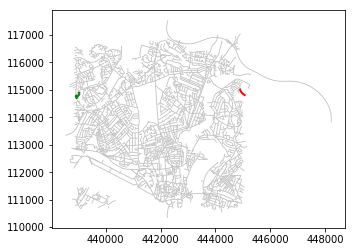

In [6]:
west_road = road_data.loc[road_data["name1"] == "Thorndike Road"]
start = west_road.iloc[0]["geometry"].coords[0][0:2]

east_road = road_data.loc[road_data["name1"] == "Meggeson Avenue"]
end = east_road.iloc[0]["geometry"].coords[0][0:2]

print(start, end)

ax = road_data.plot(color="silver", linewidth=.8)
west_road.plot(ax=ax, color="green", linewidth=2)
east_road.plot(ax=ax, color="red", linewidth=2)

Now we'll use NetworkX to find the shortest path (using [Dijkstra's algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm)) between these two roads.

This route will have to go around the Common and cross the Itchen by one of the bridges.

We'll use the length of each road segment as a weight, enabling the algorithm to determine the shortest route:

Route length: 7.2km


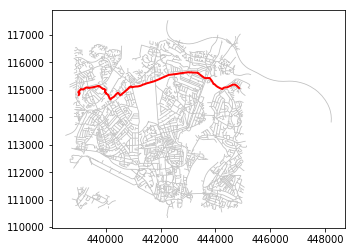

In [7]:
route = shapely.geometry.LineString(
    nx.shortest_path(
        graph,
        start,
        end,
        weight="length"
    )
)

route = gpd.GeoSeries(route, crs={"init" :"epsg:27700"})

print("Route length: {:.1f}km".format(route.length.iloc[0]/1000))

ax = road_data.plot(color="silver", linewidth=.8)
route.plot(ax=ax, color="red", linewidth=2)

Great – NetworkX has found a 7.2km route along Burgess Road and which crosses the Itchen at Woodmill.
### Add in accident data
Now we have a test route, let's add in historical accident data.

Is NetworkX / Dijkstra guiding us along direct but dangerous roads?

Road Safety data is [published by the Department for Transport](https://data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data) as point data.

Let's load it into another GeoDataFrame and clip to the same extents as the road data:

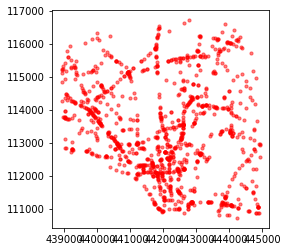

In [8]:
dir = os.path.join("/", "Users", "jamie", "Downloads", "Accidents", "*.csv") # I've saved 2015, 2016 and 2017 data here

accident_data = []
for accident_csv in glob.glob(dir):
    accident_data.append(gpd.pd.read_csv(accident_csv, low_memory=False))
accident_data = gpd.pd.concat(accident_data)

accident_data = accident_data.loc[accident_data["Local_Authority_(Highway)"] == "E06000045"] # Southampton's data
accident_data = gpd.GeoDataFrame(
    accident_data,
    crs={"init" :"epsg:27700"},
    geometry=gpd.points_from_xy(
        accident_data.Location_Easting_OSGR,
        accident_data.Location_Northing_OSGR
    )
)

accident_data = accident_data.cx[
    centre[0]-margin:centre[0]+margin,
    centre[1]-margin:centre[1]+margin
]

accident_data.plot(color="red", markersize=10, alpha=.5)

How does the accident data intersect with our route?

Let's find and plot all accidents (red dots) within 10m of each segment of the route (red line):

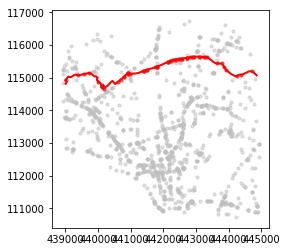

In [9]:
accident_data_on_route = accident_data.loc[accident_data.distance(route.iloc[0]) < 10]

ax = route.plot(color="red", linewidth=2)
accident_data.plot(ax=ax, color="silver", markersize=10, alpha=.5)
accident_data_on_route.plot(ax=ax, color="red", markersize=10, alpha=.5)

### Load accident data
Can we find a safer route – one that avoids common accident spots at the expense of a slightly longer way round?

So far we've used road length as the sole factor considered by the algorithm.

We'll now re-make the graph with historical accidents as an additional component in each road-segment's weight.

First we'll calculate how many accidents ocurred within 10m of each road-segment, then add that as a graph attribute:

In [10]:
def count_accidents(row):
    return len(accident_data.loc[accident_data.distance(row["geometry"]) < 10])
    
road_data["accidents"] = road_data.apply(count_accidents, axis=1) # Find accidents within 10m of each segment

graph_accidents = nx.Graph()

for index, row in road_data.iterrows():
    line = row["geometry"]
    no_of_edges = len(line.coords) - 1 # No. of sections within each road-segment
    edge_length = line.length / no_of_edges # Distribute segment length equally between edges
    edge_accidents = row["accidents"] / no_of_edges # Distribute accident count equally between edges
    for i in range(0, len(line.coords)-1):
        graph_accidents.add_edge(
            (line.coords[i][0], line.coords[i][1]),
            (line.coords[i+1][0], line.coords[i+1][1]),
            length=edge_length,
            accidents=edge_accidents
        )

print(nx.info(graph_accidents))

Name: 
Type: Graph
Number of nodes: 12346
Number of edges: 13231
Average degree:   2.1434


Now we can count how many accidents lie along our existing route:

In [11]:
def count_attr(path, graph, attr):
    count = 0
    for i in range(0, len(path)-1):
        count += graph.edges[path[i], path[i+1]][attr]
    return count

accidents_on_route = count_attr(list(route.iloc[0].coords), graph_accidents, "accidents")

accidents_msg = "There were {:.0f} accidents over this {:.1f}km route: {:.2f}/km.".format(
    accidents_on_route,
    route.iloc[0].length/1000,
    accidents_on_route / (route.iloc[0].length/1000)
)

print(accidents_msg)

There were 101 accidents over this 7.2km route: 14.09/km.


### Finding a safer way
Let's see if we can find a safer route.

We'll use the number of accidents to add additional weight to each road segment.

The new weight will encourage the algorithm to choose roads with fewer accidents (while still choosing fairly direct routes).

To illustrate, let's weight each segment as:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*length + ( length x number of accidents x risk factor )*

Where risk factor is an arbitrary number that represents the user's preference for a risk-free journey with a short one.

So a road segment of length 100m, within 50m of two accidents, with risk factor 10 would be weighted:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*100 + ( 100 x 2 x 10 ) = 2100* (or 21 times the weight of an accident-free segment)

Shortest route: There were 101 accidents over this 7.2km route: 14.09/km.
Safer route: There were 53 accidents over this 8.8km route: 6.06/km.


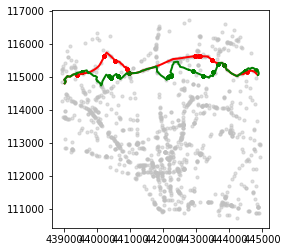

In [86]:
def calc_accidents_weight(start, end, attr):
    risk_factor = 10
    return attr["length"] + (attr["length"] * attr["accidents"] * risk_factor)

low_accident_route = shapely.geometry.LineString(
    nx.dijkstra_path( # dijkstra_path is the same as shortest_path, but allows a function for 'weight'
        graph_accidents,
        start,
        end,
        weight=calc_accidents_weight
    )
)

low_accident_route = gpd.GeoSeries(low_accident_route, crs={"init" :"epsg:27700"})

low_accident_route_count = count_attr(list(low_accident_route.iloc[0].coords), graph_accidents, "accidents")

low_accident_route_msg = "There were {:.0f} accidents over this {:.1f}km route: {:.2f}/km.".format(
    low_accident_route_count,
    low_accident_route.iloc[0].length/1000,
    low_accident_route_count / (low_accident_route.iloc[0].length/1000)
)

print("Shortest route: " + accidents_msg)
print("Safer route: " + low_accident_route_msg)

ax = accident_data.plot(color="silver", markersize=10, alpha=.5)
route.plot(ax=ax, color="red", linewidth=2)
crime_data.loc[crime_data.distance(route.iloc[0]) < 10].plot(ax=ax, color="red", markersize=10, alpha=.5)
low_accident_route.plot(ax=ax, color="green", linewidth=2)
crime_data.loc[crime_data.distance(low_accident_route.iloc[0]) < 10].plot(ax=ax, color="green", markersize=10, alpha=.5)

So the red route (the shortest) has been the site of about 100 accidents.

The green route has about half the number of accidents in exchange for a slightly longer way round.

If we're really risk-averse, we could find an eaven safer route with a higher value for `risk_factor`:

Shortest route: There were 101 accidents over this 7.2km route: 14.09/km.
Safer route: There were 53 accidents over this 8.8km route: 6.06/km.
Much safer route: There were 39 accidents over this 14.3km route: 2.77/km.


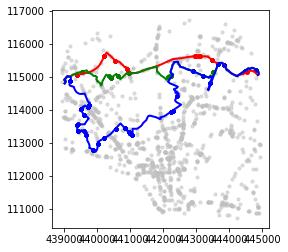

In [83]:
def calc_accidents_weight(start, end, attr):
    risk_factor = 100
    return attr["length"] + (attr["length"] * attr["accidents"] * risk_factor)

very_low_accident_route = shapely.geometry.LineString(
    nx.dijkstra_path( # dijkstra_path is the same as shortest_path, but allows a function for 'weight'
        graph_accidents,
        start,
        end,
        weight=calc_accidents_weight
    )
)

very_low_accident_route = gpd.GeoSeries(very_low_accident_route, crs={"init" :"epsg:27700"})

very_low_accident_route_count = count_attr(list(very_low_accident_route.iloc[0].coords), graph_accidents, "accidents")

very_low_accident_route_msg = "There were {:.0f} accidents over this {:.1f}km route: {:.2f}/km.".format(
    very_low_accident_route_count,
    very_low_accident_route.iloc[0].length/1000,
    very_low_accident_route_count / (very_low_accident_route.iloc[0].length/1000)
)

print("Shortest route: " + accidents_msg)
print("Safer route: " + low_accident_route_msg)
print("Much safer route: " + very_low_accident_route_msg)

ax = accident_data.plot(color="silver", markersize=10, alpha=.5)
route.plot(ax=ax, color="red", linewidth=2)
crime_data.loc[crime_data.distance(route.iloc[0]) < 10].plot(ax=ax, color="red", markersize=10, alpha=.5)
low_accident_route.plot(ax=ax, color="green", linewidth=2)
crime_data.loc[crime_data.distance(low_accident_route.iloc[0]) < 10].plot(ax=ax, color="green", markersize=10, alpha=.5)
very_low_accident_route.plot(ax=ax, color="blue", linewidth=2)
crime_data.loc[crime_data.distance(very_low_accident_route.iloc[0]) < 10].plot(ax=ax, color="blue", markersize=10, alpha=.5)

Increasing `risk_factor` to 100 finds an even safer (or at least, with fewer historical accidents) route, but at significant cost to length.

The trade-off between between safety and distance is personal: how far would you travel to reduce risk?

There's more we could do to predict safer routes which are tailored to an individual's concerns:
* Add in contextual info e.g. time and date (inc. day of week), weather conditions etc.
* Filter for type of accident e.g. vehicles involved, severity, who was injured etc.

But that's all beyond the scope of this notebook.

Let's move on to see if we can do something similar with crime data.

### Load crime data

Open data on street-level crime is [available from data.police.uk](https://data.police.uk/data/).

I've downloaded the available data from June 2016 to May 2019 for Hampshire Constabulary.

We'll aggregate the CSV files into a DataFrame, convert lat / lon to OSGB and plot the results:

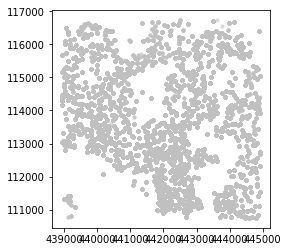

In [14]:
dir = os.path.join("/", "Users", "jamie", "Downloads", "ace8486224f830c5d03da2e62ec6aeaf338931fa", "*", "*.csv")

crime_data = []
for crime_csv in glob.glob(dir):
    crime_data.append(gpd.pd.read_csv(crime_csv))
crime_data = gpd.pd.concat(crime_data)

crime_data = gpd.GeoDataFrame(
    crime_data,
    crs={"init" :"epsg:4326"}, # The crime data is in WGS84
    geometry=gpd.points_from_xy(
        crime_data.Longitude,
        crime_data.Latitude
    )
)

crime_data = crime_data.to_crs({"init": "epsg:27700"}) # Convert to OSGB

crime_data = crime_data.cx[
    centre[0]-margin:centre[0]+margin,
    centre[1]-margin:centre[1]+margin
]

crime_data.plot(color="silver", markersize=10, alpha=.5)

### Coping with less granular data

When you look the data, it turns out that the lat / lon of each crime is less exact than that of the accident data.

(The data.police.uk site [explains why](https://data.police.uk/about/#location-anonymisation).)

The data is street-level, so no matter how long the road, there's only a few point locations.

We can see this by counting unique values of the lat / lon pairs for one road's crime:

POINT (443645.0267978894 115718.053441016)     160
POINT (440855.9709939553 115041.0177384089)     20
POINT (443109.9816636935 115636.9635018947)     12
POINT (443645.0267978894 115718.053441016)       1
Name: geometry, dtype: int64
Burgess Road is 3.0km long


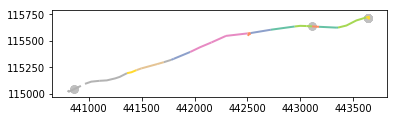

In [15]:
crime_burgess_road = crime_data.loc[crime_data["Location"] == "On or near Burgess Road"]
print(crime_burgess_road["geometry"].value_counts())

burgess_road = road_data.loc[road_data["name1"] == "Burgess Road"]

print("Burgess Road is {:.1f}km long".format(burgess_road["geometry"].length.sum() / 1000))

ax = burgess_road.plot(cmap="Set2", linewidth=2)
crime_burgess_road.plot(ax=ax, color="silver", markersize=50, alpha=.5)

Burgess Road's (3km long) data on almost 200 crimes is only geocoded to a few points.

We can still use the crime data to weight the route-finding algorithm, but we'll have to do it at road-level rather than segments.

This means the algorithm will have to make blunter choices: it can't tell whether crime is only a problem at one end of a road.

First we'll merge the road data so that each road is represented by a single line:

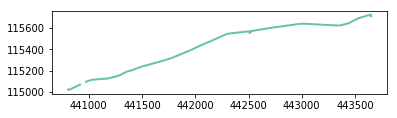

In [60]:
road_data_merged = road_data.dissolve(by="name1").reset_index() # NB turns LineStrings into MultiLineStrings
road_data_merged.loc[road_data_merged["name1"] == "Burgess Road"].plot(cmap="Set2", linewidth=2)

### Adding crime into the network
We'll now match crime data to the relevant road (we'll match by road name for simplicity).

Then we'll make a new graph of the roads, with crime as an attribute instead of accidents:

In [68]:
def count_crime(row):
    #return len(crime_data.loc[crime_data.distance(row["geometry"]) < 10])
    return len(crime_data.loc[crime_data["Location"].str.contains(row["name1"], case=False)])
    
road_data_merged["crimes"] = road_data_merged.apply(count_crime, axis=1)

graph_crime = nx.Graph()

for index, row in road_data_merged.iterrows():
    if type(row["geometry"]) == shapely.geometry.LineString:
        road = shapely.geometry.MultiLineString([row["geometry"]]) # Convert any remaining LineStrings to MultiLineStrings
    else:
        road = row["geometry"]
    road_length = row["geometry"].length # Length of whole road
    for line in road: # For each LineString in MultiLineString
        no_of_edges = len(line.coords) - 1 # No. of sections within each road-segment
        edge_length = line.length / no_of_edges # Distribute segment length equally between edges
        prop_of_road = line.length / road_length # Segment length as proportion of road length
        edge_crimes = (row["crimes"] * prop_of_road) / no_of_edges # Distribute crime count equally between edges
        for i in range(0, len(line.coords)-1):
            graph_crime.add_edge(
                (line.coords[i][0], line.coords[i][1]),
                (line.coords[i+1][0], line.coords[i+1][1]),
                length=edge_length,
                crimes=edge_crimes, # Add crime as an attribute
            )

print(nx.info(graph_crime))

Name: 
Type: Graph
Number of nodes: 10722
Number of edges: 11439
Average degree:   2.1337


Because we've changed the graph (by merging roads), we'll also re-calculate the shortest route:

In [70]:
route = shapely.geometry.LineString(
    nx.shortest_path(
        graph_crime,
        start,
        end,
        weight="length"
    )
)

route = gpd.GeoSeries(route, crs={"init" :"epsg:27700"})

crimes_on_route = count_attr(list(route.iloc[0].coords), graph_crime, "crimes")
crime_msg = "There were {:.0f} crimes over this {:.1f}km route: {:.2f}/km.".format(
    crimes_on_route,
    route.iloc[0].length/1000,
    crimes_on_route / (route.iloc[0].length/1000)
)

print(crime_msg)

There were 464 crimes over this 7.2km route: 64.50/km.


### Finding a low-crime route
Now we'll calculate a safer route, using crimes in the weight of each road:

Shortest route: There were 464 crimes over this 7.2km route: 64.50/km.
Safer route: There were 344 crimes over this 10.2km route: 33.60/km.


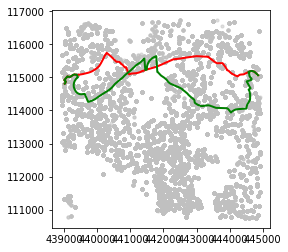

In [52]:
def calc_weight_crime(start, end, attr):
    risk_factor = 10
    return attr["length"] + (attr["length"] * attr["crimes"] * risk_factor)

low_crime_route = shapely.geometry.LineString(
    nx.dijkstra_path( # dijkstra_path is the same as shortest_path, but allows a function for 'weight'
        graph_crime,
        start,
        end,
        weight=calc_weight_crime
    )
)

low_crime_route = gpd.GeoSeries(low_crime_route, crs={"init" :"epsg:27700"})

low_crime_route_count = count_attr(list(low_crime_route.iloc[0].coords), graph_crime, "crimes")
low_crime_route_msg = "There were {:.0f} crimes over this {:.1f}km route: {:.2f}/km.".format(
    low_crime_route_count,
    low_crime_route.iloc[0].length/1000,
    low_crime_route_count / (low_crime_route.iloc[0].length/1000)
)

ax = crime_data.plot(color="silver", markersize=10, alpha=.5)
route.plot(ax=ax, color="red", linewidth=2)
low_crime_route.plot(ax=ax, color="green", linewidth=2)

print("Shortest route: " + crime_msg)
print("Safer route: " + low_crime_route_msg)

A safer route has been found, though still with a fair number of crimes, and at significant cost to route-length.

Tweaking `risk_factor` doesn't change these too much – probably because of the less granular location of the crime data.

So the crime data, because of the need to anonymise it, is less useful in this context.
### Conclusion
This notebook illustrates that data on risks (like accidents and crime) can be used with road data to find 'safer' routes.

(Of course whether these routes are truly more safe depends on whether past risks predict future ones.)

But a fairly major caveat is that the risk data must be geolocated in sufficient detail for the route that you're looking for.

For example, the locations of the crime data are insufficient for routes of 10km or so – but they might be more effective for longer routes.